In [18]:
import pandas as pd
fl= pd.read_csv("fl_statewide.csv",parse_dates=['date'])
print(fl.info())

/var/folders/_k/ttr4ghkd6w7940qsshhw9bc00000gn/T/ipykernel_16274/2155773868.py:2: DtypeWarning: Columns (3,7,10,11,13,14,17,18,19,21,22,23,24,26,27,28,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  fl= pd.read_csv("fl_statewide.csv",parse_dates=['date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7297538 entries, 0 to 7297537
Data columns (total 34 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   raw_row_number              object        
 1   date                        datetime64[ns]
 2   time                        object        
 3   location                    object        
 4   county_name                 object        
 5   subject_age                 float64       
 6   subject_race                object        
 7   subject_sex                 object        
 8   officer_id_hash             object        
 9   officer_age                 float64       
 10  officer_race                object        
 11  officer_sex                 object        
 12  officer_years_of_service    float64       
 13  department_name             object        
 14  unit                        object        
 15  type                        object        
 16  violation         

### Filtering by Date Range: April 1, 2010 to July 1, 2019
We restricted the dataset to traffic stops between April 1, 2010 and July 1, 2019 to align with the time span of the Florida census data. This ensures that comparisons between stop data and population demographics are valid and time-consistent.
This filtered subset is used for Question 1, which examines whether traffic stops disproportionately target non-white individuals. Since this question relies on population benchmarks, matching time frames avoids misleading conclusions.

In [62]:
start_date = pd.to_datetime("2010-04-01")
end_date = pd.to_datetime("2019-07-01")

# Filter the dataset
fl_date = fl[(fl['date'] >= start_date) & (fl['date'] <= end_date)]

# Preview the result
print(fl_date.shape)
print(fl_date['date'].min(), fl_date['date'].max())
fl_date.head()

(7252450, 34)
2010-04-01 00:00:00 2018-12-31 00:00:00


,raw_row_number,date,time,location,county_name,subject_age,subject_race,subject_sex,officer_id_hash,officer_age,...,reason_for_search,reason_for_stop,vehicle_registration_state,notes,raw_row_number_old,raw_Race,raw_Ethnicity,raw_row_number_new,raw_SearchType,raw_EnforcementAction
39647,40906|1443094|6292932,2010-04-01,00:04:46,NaN,Okaloosa County,26.0,white,female,50682433c7,40.0,...,NaN,SPEED,FL,Traffic Warning;Traffic Warning,-----|-------,W,NaN,-------,NO SEARCH REQUESTED,WARNING
39648,40907|1443095,2010-04-01,00:05:30,NaN,Hillsborough County,19.0,black,male,61b9fce8e1,NaN,...,NaN,NaN,FL,Uniform Traffic Citation,-----|-------,B,NaN,NaN,NaN,NaN
39649,40908|1443096|8936268,2010-04-01,00:06:04,NaN,Polk County,27.0,white,female,42c8fa42f7,51.0,...,NaN,SPEED,FL,Uniform Traffic Citation;Uniform Traffic Citation,-----|-------,W,NaN,-------,NO SEARCH REQUESTED,INFRACTION ARREST
39650,40909|1443097,2010-04-01,00:08:13,NaN,Okaloosa County,42.0,white,male,db19362e5d,NaN,...,NaN,NaN,GA,Uniform Traffic Citation,-----|-------,W,NaN,NaN,NaN,NaN
39651,40910|1443098|8379718,2010-04-01,00:11:36,NaN,Bay County,21.0,white,female,c62a040454,45.0,...,NaN,SPEED,KY,Traffic Warning;Traffic Warning,-----|-------,W,NaN,-------,NO SEARCH REQUESTED,WARNING|FAULTY EQUIPMENT NOTICE


Extract key columns to analyze whether searches during traffic stops disproportionately target non-white individuals. Focus on `subject_race`, `search_conducted`, `date`, and `county_name` for core analysis, with optional controls like `subject_sex` and `subject_age` to refine results.

`location` has too many nulls

In [96]:
cols = [
    'date', 'subject_race', 'search_conducted',
    'county_name', 'subject_sex', 'subject_age']
fl_q1 = fl_date[cols]
fl_q1 = fl_q1.dropna()

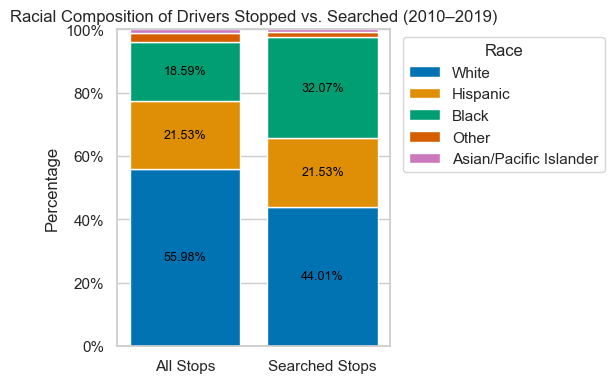

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.ticker as mtick

# Step 1: Proportion data for all stops and searches
stops = fl_q1['subject_race'].value_counts(normalize=True)
searched = fl_q1[fl_q1['search_conducted'] == True]['subject_race'].value_counts(normalize=True)

# Step 2: Use stop proportions to define order
races = stops.sort_values(ascending=False).index.tolist()

# Step 3: Reindex both series using unified race order
stops, searched = stops.reindex(races, fill_value=0), searched.reindex(races, fill_value=0)

# Step 4: Get top 3 race groups for labeling
top3 = {
    'All Stops': stops.head(3).index.tolist(),
    'Searched Stops': searched.head(3).index.tolist()
}

# Step 5: Color palette
colors = dict(zip(races, sns.color_palette("colorblind", n_colors=len(races))))

# Step 6: Plot
fig, ax = plt.subplots(figsize=(6, 4))
bottoms = {'All Stops': 0, 'Searched Stops': 0}

for race in races:
    for group, data in {'All Stops': stops, 'Searched Stops': searched}.items():
        height = data[race]
        if height > 0:
            ax.bar(group, height, bottom=bottoms[group], color=colors[race])

            if race in top3[group]:
                ax.text(
                    group,
                    bottoms[group] + height / 2,
                    f"{height*100:.2f}%",
                    ha='center', va='center',
                    fontsize=9, color='black'
                )
            bottoms[group] += height

# Step 7: Legend and formatting
handles = [Patch(facecolor=colors[r], label=r.title()) for r in races]
ax.legend(handles=handles, title="Race", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_title("Racial Composition of Drivers Stopped vs. Searched (2010–2019)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("Percentage")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [105]:
census_raw = pd.read_excel("fl-census.xlsx", skiprows=3)
# Step 1: Define mapping from census rows to traffic stop categories
race_map = {
    '..White': 'White',
    '..Black or African American': 'Black',
    '.HISPANIC': 'Hispanic',
    '..Asian': 'Asian',
    '..Native Hawaiian and Other Pacific Islander': 'Pacific Islander',
    '..American Indian and Alaska Native': 'Other',
    '.Two or More Races': 'Other'
}

# Step 2: Filter rows you need
census_filtered = census_raw[census_raw['Unnamed: 0'].isin(race_map.keys())].copy()
census_filtered['Race'] = census_filtered['Unnamed: 0'].map(race_map)

# Step 3: Compute average population from 2010 to 2019
# Ensure all column names are strings for consistent indexing
census_filtered.columns = census_filtered.columns.map(str)
year_cols = [str(year) for year in range(2010, 2020)]
census_filtered['Average'] = census_filtered[year_cols].mean(axis=1)

# Step 4: Group and sum to match your 5 categories
census_grouped = census_filtered.groupby('Race')['Average'].sum()

# Step 5: Combine Asian + Pacific Islander
if 'Asian' in census_grouped and 'Pacific Islander' in census_grouped:
    census_grouped['Asian/Pacific Islander'] = (
        census_grouped['Asian'] + census_grouped['Pacific Islander']
    )
    census_grouped = census_grouped.drop(['Asian', 'Pacific Islander'])

# Step 6: Normalize to proportions
census_proportions = (census_grouped / census_grouped.sum()).round(4) * 100
print(census_proportions)

Race
Black                     15.30
Hispanic                  10.82
Other                      1.54
White                     69.46
Asian/Pacific Islander     2.88
Name: Average, dtype: float64


### Table

In [114]:
# Recalculate traffic stop/search shares for matching races
stops = fl_q1['subject_race'].value_counts(normalize=True) * 100
searched = fl_q1[fl_q1['search_conducted'] == True]['subject_race'].value_counts(normalize=True) * 100

# Define unified race order
races = ['white', 'black', 'hispanic', 'asian/pacific islander', 'other']

census_proportions.index = census_proportions.index.str.lower()

# Build summary table
summary_table = pd.DataFrame({
    'Population % (2010–2019 avg.)': census_proportions.reindex(races),
    'All Stops %': stops.reindex(races),
    'Searched Stops %': searched.reindex(races)
}).round(2)

summary_table.index = summary_table.index.str.title()
print(summary_table)


                        Population % (2010–2019 avg.)  All Stops %  \
White                                           69.46        55.98   
Black                                           15.30        18.59   
Hispanic                                        10.82        21.53   
Asian/Pacific Islander                           2.88         1.28   
Other                                            1.54         2.61   

                        Searched Stops %  
White                              44.01  
Black                              32.07  
Hispanic                           21.53  
Asian/Pacific Islander              0.68  
Other                               1.71  


In [65]:
print(fl_q1['search_conducted'].unique())

[False True]


plt.title("Racial Distribution Among All Searched Drivers (April 1, 2010 - July 1, 2019)")

### Bar Chart: Stop/Search/Population Proportions by Race

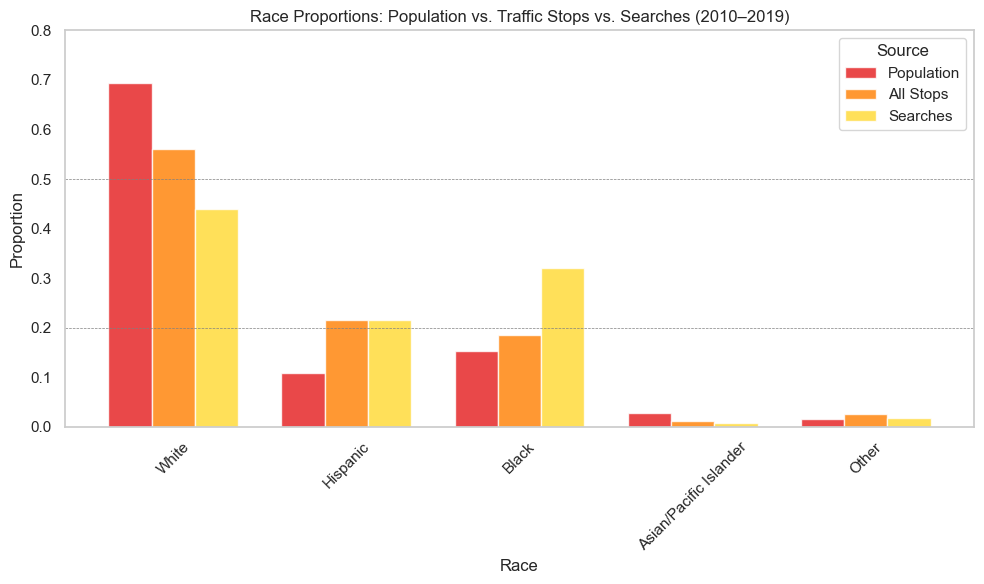

In [117]:
# Updated values based on user's screenshot
chart_data_updated = pd.DataFrame({
    'Population': [0.6946, 0.1082, 0.1530, 0.0288, 0.0154],
    'All Stops':  [0.5598, 0.2153, 0.1859, 0.0128, 0.0261],
    'Searches':   [0.4401, 0.2153, 0.3207, 0.0068, 0.0171]
}, index=['White', 'Hispanic', 'Black', 'Asian/Pacific Islander', 'Other'])

# Plot updated grouped bar chart
custom_warm_colors = ['#e41a1c', '#ff7f00', '#ffd92f']
ax = chart_data_updated.plot(kind='bar', figsize=(10, 6), width=0.75,color=custom_warm_colors,alpha=0.8)
plt.title("Race Proportions: Population vs. Traffic Stops vs. Searches (2010–2019)")
plt.ylabel("Proportion")
plt.xlabel("Race")
plt.ylim(0, 0.8)
plt.axhline(0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)
plt.legend(title="Source")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


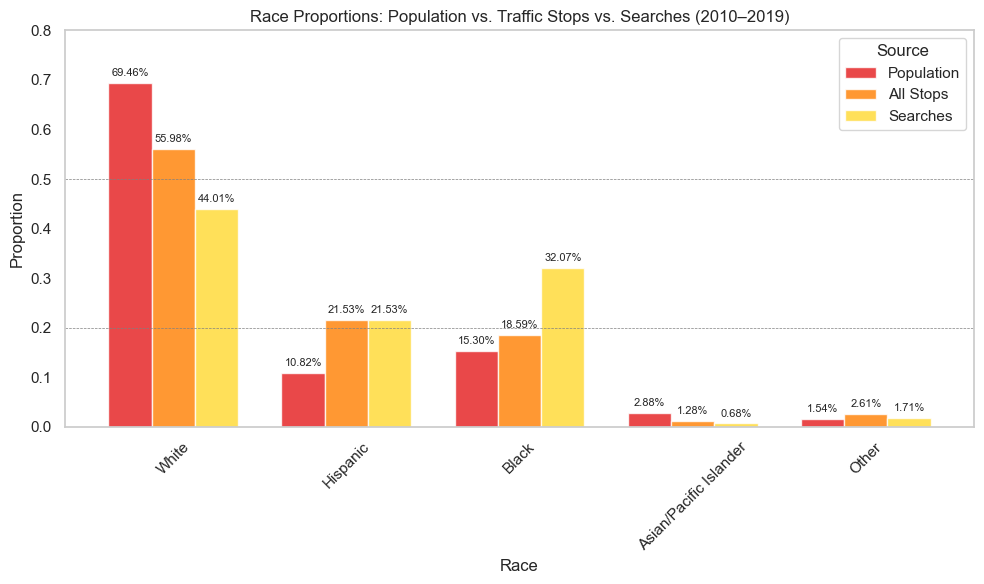

In [137]:
# Re-import necessary packages after kernel reset
import pandas as pd
import matplotlib.pyplot as plt

# Updated values based on user's screenshot
chart_data_updated = pd.DataFrame({
    'Population': [0.6946, 0.1082, 0.1530, 0.0288, 0.0154],
    'All Stops':  [0.5598, 0.2153, 0.1859, 0.0128, 0.0261],
    'Searches':   [0.4401, 0.2153, 0.3207, 0.0068, 0.0171]
}, index=['White', 'Hispanic', 'Black', 'Asian/Pacific Islander', 'Other'])

# Plot updated grouped bar chart with annotations
custom_warm_colors = ['#e41a1c', '#ff7f00', '#ffd92f']
ax = chart_data_updated.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.75,
    color=custom_warm_colors,
    alpha=0.8
)

plt.title("Race Proportions: Population vs. Traffic Stops vs. Searches (2010–2019)")
plt.ylabel("Proportion")
plt.xlabel("Race")
plt.ylim(0, 0.8)
plt.axhline(0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)
plt.legend(title="Source")
plt.xticks(rotation=45)
plt.grid(False)

# Add value annotations as percentages
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height * 100:.2f}%",
                ha='center',
                va='bottom',
                fontsize=8
            )

plt.tight_layout()
plt.show()


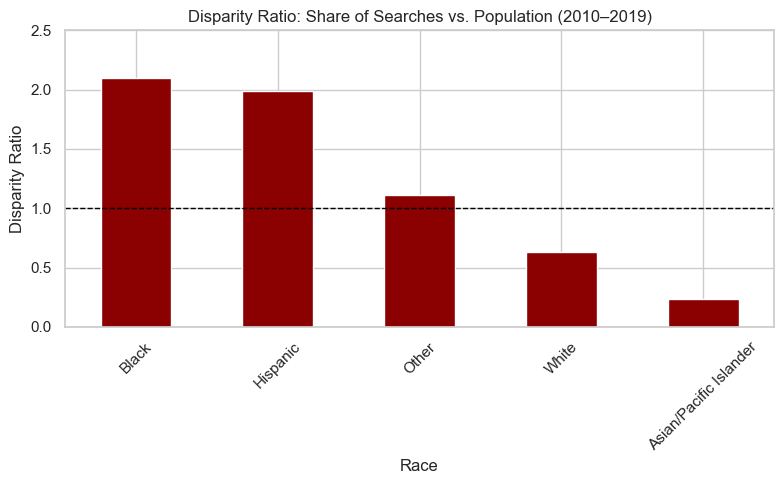

In [120]:
# Calculate disparity ratio = Searches % / Population %
disparity_ratio = chart_data_updated['Searches'] / chart_data_updated['Population']

# Plot
plt.figure(figsize=(8, 5))
disparity_ratio.sort_values(ascending=False).plot(kind='bar', color='darkred')
plt.axhline(1.0, color='black', linestyle='--', linewidth=1)
plt.title("Disparity Ratio: Share of Searches vs. Population (2010–2019)")
plt.ylabel("Disparity Ratio")
plt.xlabel("Race")
plt.ylim(0, 2.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Chi-Square Test

In [131]:
from scipy.stats import chisquare

search_total = (fl_q1['search_conducted'] == True).sum()

# Use your summary table proportions
observed = summary_table['Searched Stops %'] / 100 * search_total
expected = summary_table['Population % (2010–2019 avg.)'] / 100 * search_total

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Display result
print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.4f}")

Chi-square statistic: 8749.42
p-value: 0.0000


In [140]:
print(fl_q1['search_conducted'].shape)

(3640944,)
